## Notebook Import

In [1]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer #for text stemming
from nltk.stem import SnowballStemmer #for text stemming
from nltk.corpus import stopwords #to remove stopwords
from nltk.tokenize import word_tokenize #for tokenization
from wordcloud import WordCloud #for wordcloud visulization
from PIL import Image #for image manipulation and procesing

from bs4 import BeautifulSoup #to remove html tags
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score

from sklearn.model_selection import train_test_split # for data spliting

sns.set()

## Files Import

In [2]:
EXAMPLE_FILE = 'C:/github/SpamData/01_Processing/practice_email.txt' 

SPAM_1_PATH = 'C:/github/SpamData/01_Processing/spam_1'
SPAM_2_PATH = 'C:/github/SpamData/01_Processing/spam_2'
EASY_NONSPAM_1_PATH = 'C:/github/SpamData/01_Processing/easy_ham_1'
EASY_NONSPAM_2_PATH = 'C:/github/SpamData/01_Processing/easy_ham_2'

DATA_JSON_FILE = 'C:/github/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'C:/github/SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'C:/github/SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'C:/github/SpamData/02_Training/test-data.txt'

SKULL_FILE = 'C:/github/SpamData/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'C:/github/SpamData/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'C:/github/SpamData/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'C:/github/SpamData/wordcloud_resources/OpenSansCondensed-Bold.ttf'

SPAM_CAT = 1 #category spam
HAM_CAT = 0 #category non-spam
VOCAB_SIZE = 2500

# Dataset
[Dataset link Googledrive](https://drive.google.com/drive/folders/11HcakVtzxpvnz9CCxzBOpbMtm25Ev5iH?usp=sharing)

# Project Report
[Project Report Link Googledrive](https://drive.google.com/file/d/1f1vS4D4bseEFRSVZ3amsI99zsVJb34BV/view?usp=sharing)

## Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
#defualt system encording
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

# creating a loop to print only the message body
is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Function

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [7]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [8]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1)) #append SPAM_2_PATH to SPAM_1_PATH
spam_emails.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)) #append EASY_NONSPAM_2_PATH to EASY_NONSPAM_1_PATH
ham_emails.shape

(3951, 2)

In [13]:
data = pd.concat([spam_emails, ham_emails]) #adding both emails together
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5849, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [14]:
data.tail()

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


## Data Cleaning: Checking for Missing Values

In [15]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [16]:
type("")

str

In [17]:
len("")

0

In [18]:
my_var = None

In [19]:
type(my_var)

NoneType

In [20]:
# check for empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [21]:
(data.MESSAGE.str.len() == 0).sum()

2

In [22]:
# Checking the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [23]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [24]:
data[data.MESSAGE.str.len() == 0].index #locating index where condition is true

Index(['cmds', 'cmds'], dtype='object')

# Remove System File Entries from Dataframe

In [25]:
data.drop(['cmds'], inplace=True)

data.shape

(5847, 2)

# Add Document IDs to Track Emails in Dataset

In [26]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [27]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


# Save to File using Pandas

In [28]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [29]:
data.CATEGORY.value_counts()

0    3951
1    1896
Name: CATEGORY, dtype: int64

In [30]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

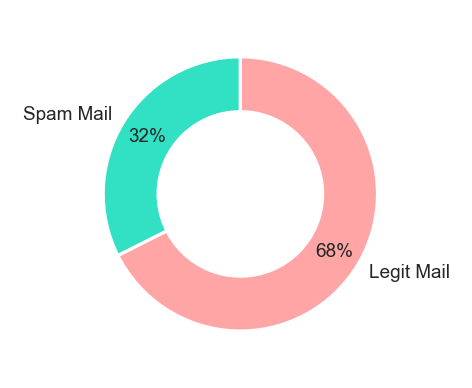

In [31]:
#visualize with donut chat
category_names = ['Spam Mail', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#32e0c4', '#ffa5a5']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle to create a donut chart
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing NLP
#### Download the NLTK Resources (Tokenizer & Stopwords)

In [32]:
nltk.download('punkt') # Punkt Sentence Tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Removing Stop Words 

In [35]:
stop_words = set(stopwords.words('english')) # convert the stopwords to set

In [36]:
type(stop_words)

set

In [37]:
if 'this' in stop_words: print('Found it!')

Found it!


In [38]:
if 'hello' not in stop_words: print('Oops Nope!')

Oops Nope!


## Removing Punctuation

In [39]:
'w'.isalpha() # check for a charater

True

In [40]:
'?'.isalpha() # check for a puntuation

False

## Removing HTML tags from Emails

In [41]:
soup = BeautifulSoup(data.at[5, 'MESSAGE'], 'html.parser') # the text and the parser we like to use. built in
print(soup.prettify())

A POWERHOUSE GIFTING PROGRAM You Don't Want To Miss! 

 

  GET IN WITH THE FOUNDERS! 

The MAJOR PLAYERS are on This ONE

For ONCE be where the PlayerS are

This is YOUR Private Invitation



EXPERTS ARE CALLING THIS THE FASTEST WAY 

TO HUGE CASH FLOW EVER CONCEIVED

Leverage $1,000 into $50,000 Over and Over Again



THE QUESTION HERE IS:

YOU EITHER WANT TO BE WEALTHY 

OR YOU DON'T!!!

WHICH ONE ARE YOU?

I am tossing you a financial lifeline and for your sake I 

Hope you GRAB onto it and hold on tight For the Ride of youR life!



Testimonials



Hear what average people are doing their first few days:

We've received 8,000 in 1 day and we are doing that over and over again!' Q.S. in AL

 I'm a single mother in FL and I've received 12,000 in the last 4 days. D. S. in FL

I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day! L.L. in KY

I didn't have the money, so I found myself a partner to work this with. We have received $4,

In [42]:
soup.get_text() # to remove all html

'A POWERHOUSE GIFTING PROGRAM You Don\'t Want To Miss! \n\n \n\n  GET IN WITH THE FOUNDERS! \n\nThe MAJOR PLAYERS are on This ONE\n\nFor ONCE be where the PlayerS are\n\nThis is YOUR Private Invitation\n\n\n\nEXPERTS ARE CALLING THIS THE FASTEST WAY \n\nTO HUGE CASH FLOW EVER CONCEIVED\n\nLeverage $1,000 into $50,000 Over and Over Again\n\n\n\nTHE QUESTION HERE IS:\n\nYOU EITHER WANT TO BE WEALTHY \n\nOR YOU DON\'T!!!\n\nWHICH ONE ARE YOU?\n\nI am tossing you a financial lifeline and for your sake I \n\nHope you GRAB onto it and hold on tight For the Ride of youR life!\n\n\n\nTestimonials\n\n\n\nHear what average people are doing their first few days:\n\n\x93We\'ve received 8,000 in 1 day and we are doing that over and over again!\' Q.S. in AL\n\n \x93I\'m a single mother in FL and I\'ve received 12,000 in the last 4 days.\x94 D. S. in FL\n\n\x93I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!\x94 L.L. in KY\n\n\x93I didn\'t have the 

## Functions for Email Processing

In [43]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [44]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [45]:
# Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [46]:
clean_msg_no_html(data.at[5, 'MESSAGE'])

['powerhous',
 'gift',
 'program',
 'want',
 'miss',
 'get',
 'founder',
 'major',
 'player',
 'one',
 'player',
 'privat',
 'invit',
 'expert',
 'call',
 'fastest',
 'way',
 'huge',
 'cash',
 'flow',
 'ever',
 'conceiv',
 'leverag',
 'question',
 'either',
 'want',
 'wealthi',
 'one',
 'toss',
 'financi',
 'lifelin',
 'sake',
 'hope',
 'grab',
 'onto',
 'hold',
 'tight',
 'ride',
 'life',
 'testimoni',
 'hear',
 'averag',
 'peopl',
 'first',
 'day',
 'receiv',
 'day',
 'al',
 'singl',
 'mother',
 'fl',
 'receiv',
 'last',
 'fl',
 'sure',
 'sent',
 'pledg',
 'got',
 'back',
 'next',
 'day',
 'ky',
 'money',
 'found',
 'partner',
 'work',
 'receiv',
 'last',
 'day',
 'think',
 'made',
 'right',
 'decis',
 'fl',
 'pick',
 'first',
 'day',
 'gave',
 'free',
 'lead',
 'train',
 'ca',
 'announc',
 'close',
 'sale',
 'help',
 'get',
 'fax',
 'blast',
 'immedi',
 'upon',
 'entri',
 'make',
 'money',
 'free',
 'lead',
 'train',
 'wait',
 'call',
 'fax',
 'back',
 'call',
 'best',
 'time',
 'me

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [47]:
data.iat[2, 2] # Access a single value for a row/column pair by integer position. in this case its the FILE_NAME

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [48]:
data.iloc[5:11] # to select a subset of the data

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [49]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [50]:
flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

321

In [51]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [52]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\Admin\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp






" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 1min 4s


In [53]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [54]:
nested_list.tail()

DOC_ID
5842    [http, bizarr, collect, stuf, anim, could, fet...
5843    [care, use, one, also, realli, cute, thing, ja...
5844    [sm, skip, montanaro, write, jeremi, put, anot...
5845    [mark, hammond, like, given, zodb, sound, attr...
5846    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [55]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [56]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
1891,1,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,1,This is a multi-part message in MIME format.\n...,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,1,"Dear Subscriber,\n\n\n\nIf I could show you a ...",01398.8ca7045aae4184d56e8509dc5ad6d979
1894,1,****Mid-Summer Customer Appreciation SALE!****...,01399.2319643317e2c5193d574e40a71809c2
1895,1,ATTN:SIR/MADAN \n\n\n\n ...,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [57]:
# two variables (doc_ids_spam, doc_ids_ham) which hold onto the indices for the spam and the non-spam emails respectively. 
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [58]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5837, 5838, 5839, 5840, 5841, 5842, 5843, 5844, 5845, 5846],
           dtype='int64', name='DOC_ID', length=3951)

### Subsetting a Series with an Index

In [59]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [60]:
type(nested_list)

pandas.core.series.Series

In [61]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [62]:
nested_list_ham.shape

(3951,)

In [63]:
nested_list_ham.tail()

DOC_ID
5842    [http, bizarr, collect, stuf, anim, could, fet...
5843    [care, use, one, also, realli, cute, thing, ja...
5844    [sm, skip, montanaro, write, jeremi, put, anot...
5845    [mark, hammond, like, given, zodb, sound, attr...
5846    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [64]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [65]:
# python list comprehension to find the total number of words in our cleaned dataset of non-spam email bodies.
# the total number of words in normal emails in the dataset. the 10 most common words used in non-spam 
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20465

In [66]:
normal_words[:10]

http      7675
use       3683
list      2934
one       2375
mail      2326
get       2316
would     2046
like      1947
messag    1883
work      1831
dtype: int64

In [67]:
# python list comprehension to find the total number of words in our cleaned dataset of spam email bodies.
# the total number of words in normal emails in the dataset. the 10 most common words used in spam
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13284

In [68]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

# Creating a Word Cloud

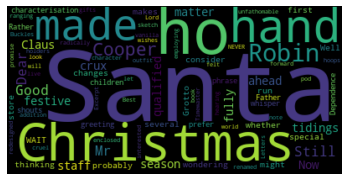

In [69]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [70]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
len(hamlet_corpus)

37360

In [71]:
type(hamlet_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [72]:
hamlet_corpus

['[', 'The', 'Tragedie', 'of', 'Hamlet', 'by', ...]

In [73]:
word_list = [''.join(word) for word in hamlet_corpus]
novel_as_string = ' '.join(word_list)

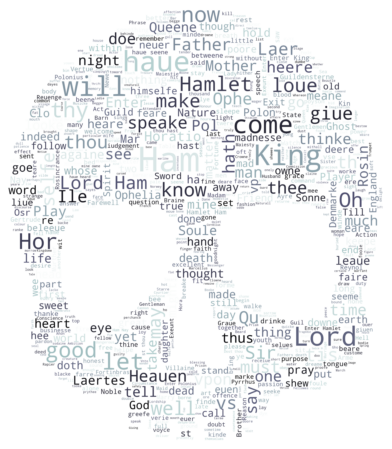

In [74]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=700, colormap='bone')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud of Ham Messages

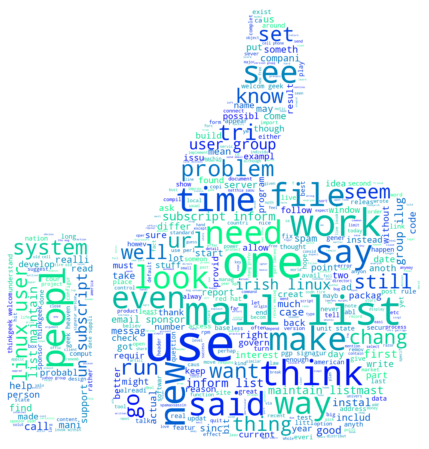

In [75]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud of Spam Messages

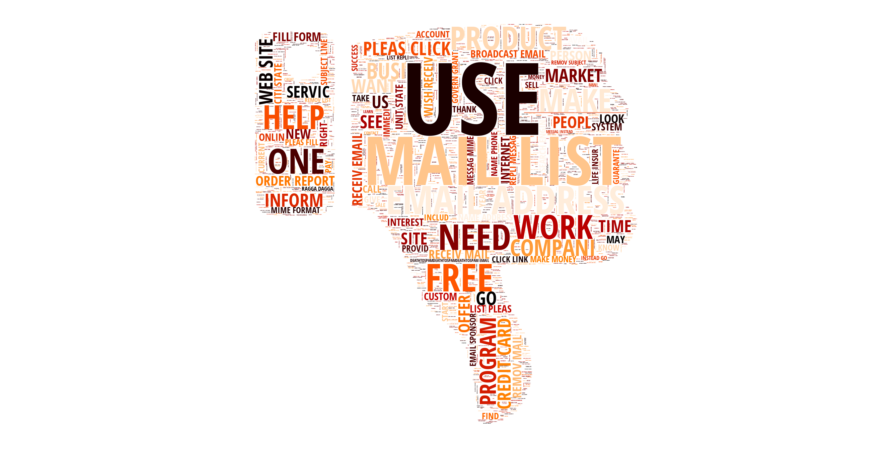

In [76]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                       max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [77]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [78]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words:', unique_words.shape[0])
unique_words.head()

Nr of unique words: 27051


http     10776
use       5070
list      4908
email     4347
get       4219
dtype: int64

In [79]:
#subset of the series that only contains the most common 2,500 words out of the total.
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10776
use       5070
list      4908
email     4347
get       4219
mail      4056
one       3909
free      3182
time      3106
work      2913
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [80]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [81]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Checking if a Word is Part of the Vocabulary

In [82]:
any(vocab.VOCAB_WORD == 'free') # inefficient

True

In [83]:
'machine' in set(vocab.VOCAB_WORD) # better way

False

# The Email with the Most Number of Words

In [84]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [85]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [86]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))


Email position in the list (and the data dataframe) 5826


In [87]:
stemmed_nested_list[np.argmax(clean_email_lengths)]


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [88]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']


'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [89]:
type(stemmed_nested_list)

pandas.core.series.Series

In [90]:
type(stemmed_nested_list.tolist()) # convert to list

list

In [91]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [92]:
word_columns_df.shape

(5847, 7671)

### Splitting the Data into a Training and Testing Dataset

In [93]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [94]:
print('Nr. of training samples:', X_train.shape[0])
print('Fraction of training set:', X_train.shape[0] / word_columns_df.shape[0])

Nr. of training samples: 4092
Fraction of training set: 0.6998460749102103


In [95]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
568,mime,messag,html,messag,free,comput,merchant,account,setup,complet,...,None,None,None,None,None,None,None,None,None,None
4050,url,http,date,seem,like,attw,offer,servic,tell,friend,...,None,None,None,None,None,None,None,None,None,None
3435,inlin,fri,sep,josh,hildebrand,wrote,unfortun,run,complain,h,...,None,None,None,None,None,None,None,None,None,None
3165,mon,sep,matthia,saou,wrote,build,origin,sourc,mention,one,...,None,None,None,None,None,None,None,None,None,None
3941,url,http,date,ugli,guy,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [96]:
y_train.head()

DOC_ID
568     1
4050    0
3435    0
3165    0
3941    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [97]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [99]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [100]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 6min 25s


In [101]:
sparse_train_df.shape

(441938, 4)

In [102]:
sparse_train_df[:5] # top five rows

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,568,1,1,435
1,568,1,1,10
2,568,1,1,684
3,568,1,1,10
4,568,1,1,7


In [103]:
sparse_train_df[-5:] # last five rows

,DOC_ID,LABEL,OCCURENCE,WORD_ID
441933,860,1,1,48
441934,860,1,1,1445
441935,860,1,1,26
441936,860,1,1,21
441937,860,1,1,126


### Combine Occurrences with the Pandas groupby() Method

In [104]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [105]:
vocab.at[7, 'VOCAB_WORD']

'free'

In [106]:
data.MESSAGE[7]

'<html>\n\n<head>\n\n<title>ReliaQuote - Save Up To 70% On Life Insurance</title>\n\n<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1">\n\n</head>\n\n<body leftmargin="0" topmargin="0" link="#FFCC99" vlink="#FFCC99" alink="#FFCC00">\n\n<table align="center" width="468" border="0" cellspacing="0" cellpadding="0" height="500" bgcolor="993366">\n\n  <tr>\n\n    <td align="left" valign="top" height="43" width="56%">\n\n      <table width="100%" border="0" cellspacing="0" cellpadding="3">\n\n        <tr>\n\n          <td><a href="http://theadmanager.com/server/c.asp?ad_key=YUESBHWAKMLK&ext=1" target="_blank"><img src="http://www.reliaquote.com/banner/bannerads/images/logo6.gif" width="120" height="32" border="0"></a></td>\n\n        </tr>\n\n      </table>\n\n    </td>\n\n    <td align="left" valign="top" height="43" width="44%">&nbsp;</td>\n\n  </tr>\n\n  <tr>\n\n    <td align="left" valign="top" width="56%" height="377">\n\n      <table width="100%" border="0" cellsp

In [107]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [108]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
261119,5846,2020,0,13
261120,5846,2032,0,1
261121,5846,2341,0,1
261122,5846,2346,0,1
261123,5846,2480,0,1


In [110]:
data.MESSAGE[5846]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [111]:
train_grouped.shape

(261124, 4)

### Save Training Data as .txt File

In [112]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [113]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [114]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5110,key,concept,tokyo,urban,overh,climat,chang,remedi,attent,conserv,...,None,None,None,None,None,None,None,None,None,None
3309,polit,news,r,u,h,u,use,justin,mason,wrote,...,None,None,None,None,None,None,None,None,None,None
4233,url,http,date,suppli,brief,interview,bo,bo,zine,blog,...,None,None,None,None,None,None,None,None,None,None
5527,yet,anoth,wave,peopl,know,seem,lost,job,last,week,...,None,None,None,None,None,None,None,None,None,None
681,messag,mime,format,dc,motor,gear,motor,new,offer,custom,...,None,None,None,None,None,None,None,None,None,None


In [115]:
y_test.head()

DOC_ID
5110    0
3309    0
4233    0
5527    0
681     1
Name: CATEGORY, dtype: int64

In [116]:
X_test.shape

(1755, 7671)

In [117]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 2min 32s


In [118]:
sparse_test_df.shape

(200563, 4)

In [119]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [120]:
test_grouped.shape

(118733, 4)

### Save Training Data as .txt File

In [121]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

## Pre-Processing Subtleties

In [122]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [123]:
len(test_doc_ids)

1739

In [124]:
len(X_test)

1755

In [125]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

{73,
 134,
 179,
 240,
 274,
 298,
 339,
 439,
 471,
 670,
 734,
 765,
 945,
 1544,
 1670,
 1700}

In [126]:
data.MESSAGE[734]

'<html>\n\n<body bgcolor="#7CB5F0">\n\n<a href="http://teens.xxxfreehosting.com/hotteens/index.html"><img border="0" src="http://members.aol.com/tjoyce/mail_01.gif" width="500" height="558" border=0></a><br>\n\n<a href="mailto:flojo@btamail.net.cn"><img border="0" src="http://members.aol.com/tjoyce/mail_02.gif" width="500" height="42" border=0>\n\n</a>\n\n</body>\n\n</html>\n\n4623\n\n\n\n\n'

In [127]:
data.loc[734]

CATEGORY                                                     1
MESSAGE      <html>\n\n<body bgcolor="#7CB5F0">\n\n<a href=...
FILE_NAME               00235.749db1b61dbea4257300c71c9220a4e8
Name: 734, dtype: object

In [128]:
clean_msg_no_html(data.at[734, 'MESSAGE'])

[]

In [129]:
clean_message(data.at[734, 'MESSAGE'])

['html', 'bodi', 'http', 'img', 'http', 'br', 'mailto', 'flojo', 'img', 'http']